In [4]:
import pickle
import spike.spike_analysis.pca_trajectories as pcat
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_collection as sc
import spike.spike_analysis.spike_recording as recording
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import seaborn as sns
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    


In [3]:

def plot_pca_results_3d(pca_result, title, colors, azim, elev, save = False):
    event_lengths = int(
            (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
        )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    #plt.subplots_adjust(left=0.3, right=0.99, bottom=0.1, top=0.9)
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        ax.plot3D(
            PCA_matrix[i : i + event_lengths, 0],
            PCA_matrix[i : i + event_lengths, 1],
            PCA_matrix[i : i + event_lengths, 2],
            label=event_label,
            color=colors[col_counter],
            linewidth = 5,
            alpha = 0.8
        )
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            PCA_matrix[i, 2],
            marker="s",
            s=100,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            PCA_matrix[onset, 2],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            PCA_matrix[end, 2],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                PCA_matrix[post, 2],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
            )
        col_counter += 1
    ax.legend(loc="upper left", bbox_to_anchor=(.9,1), frameon = False, fontsize = 14)
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    # ax.set_zlim(-20, 30)
    ax.view_init(azim = azim, elev =elev)
    ax.set_title(f"{title}", fontsize = 24, y = 1)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_zlabel(f"PC3 ({pc_var[2]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.yaxis.pane.set_alpha(0.9)
    ax.xaxis.pane.set_alpha(0.9)
    ax.zaxis.pane.set_alpha(0.9)
    plt.tight_layout()
    if save:
        plt.savefig(f'{title}.png', dpi = 600, transparent = True,bbox_inches='tight' )
    plt.show()


def plot_pca_results_2d(pca_result, title, colors, legend_spot, save=False):
    event_lengths = int(
        (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
    )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    
    # Create figure with updated size
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        
        # Plot the continuous line with updated styling
        ax.plot(
            PCA_matrix[i:i + event_lengths, 0],
            PCA_matrix[i:i + event_lengths, 1],
            label=event_label,
            color=colors[col_counter],
            linewidth=5,
            alpha=0.8,
            zorder = 1
        )
        
        # Add markers with updated sizes
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            marker="s",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 2
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 3
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 4
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
                zorder =5
            )
        col_counter += 1
    
    # Updated legend formatting
    ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)
    
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    
    # Updated title and label formatting
    ax.set_title(f"{title}", fontsize=24, y=1.01)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize=16)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize=16)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Add tight layout
    plt.tight_layout()
    
    if save:
        plt.savefig(f'{title}.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

In [7]:
only_subjects_spike = sc.SpikeCollection.load_collection(r"pilot2\only_subjects\only_subjects_spike_collection\spike_collection.json")


In [8]:
only_subjects_spike.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)


All set to analyze


Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\megha\AppData\Local\Temp\ipykernel_44696\677874798.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


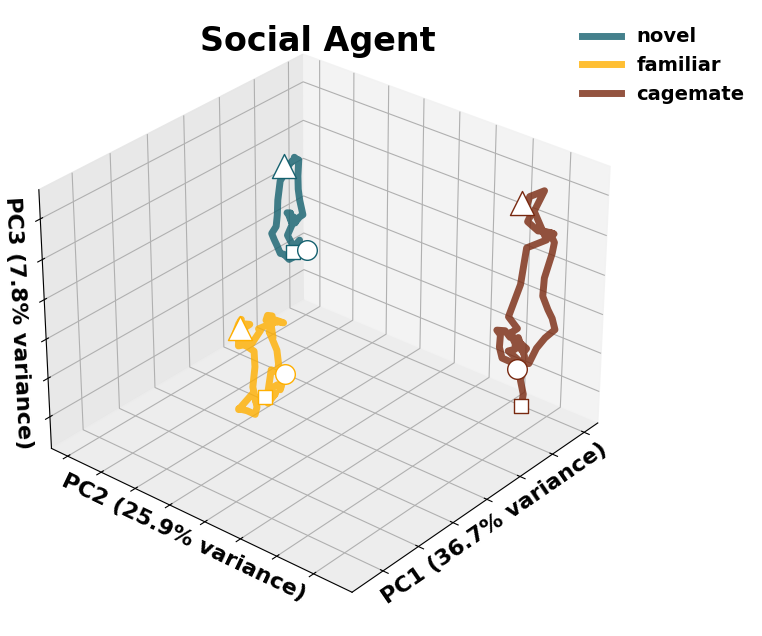

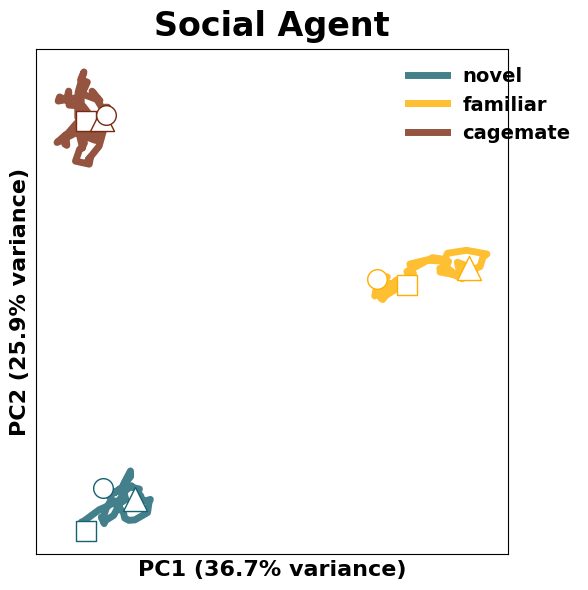

PCA Result with:
Events: novel, familiar, cagemate
Timebins per event: 50.0
Total neurons: 150
Number of recordings: 12
Number of Pcs needed to explain 90% of variance 12


In [13]:

agent_pca_results = pcat.avg_trajectories_pca(only_subjects_spike, 3, 2, events = ['novel', 'familiar', 'cagemate'], min_neurons=5, plot = False)
order_pca_results = pcat.avg_trajectories_pca(only_subjects_spike, 3, 2, events = ['exposure 1', 'exposure 2', 'exposure 3'],min_neurons=5, plot = False)

exp_colors = [hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910')]
agent_colors = ['#15616F',
                '#FFAF00',
                '#792910']
plot_pca_results_3d(agent_pca_results, "Social Agent", agent_colors, azim = 40, elev = 30)
plot_pca_results_2d(agent_pca_results, "Social Agent", colors = agent_colors, legend_spot = (0.75, 1))

print(agent_pca_results)

C:\Users\megha\AppData\Local\Temp\ipykernel_44696\677874798.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


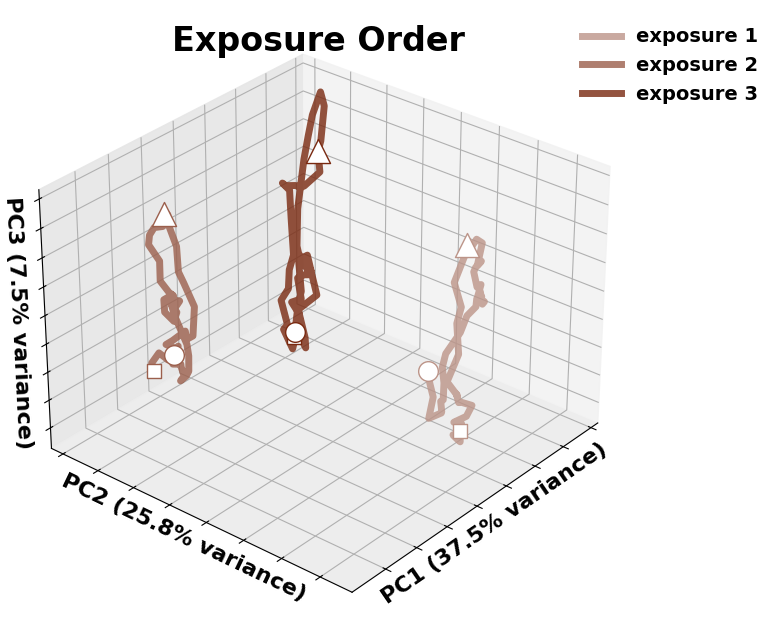

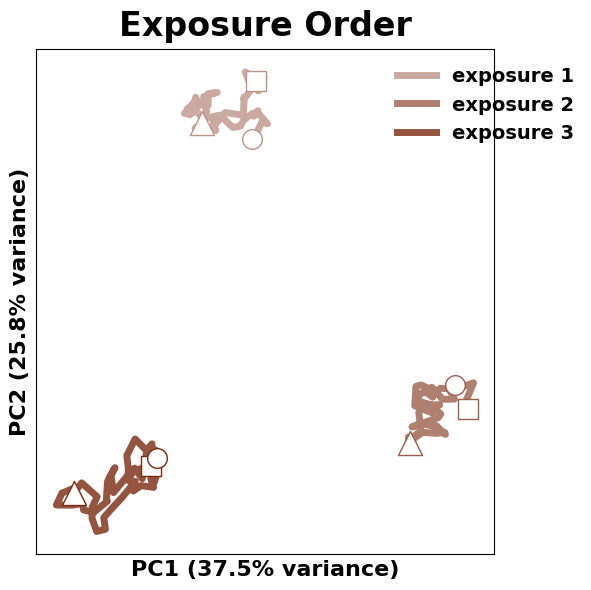

PCA Result with:
Events: exposure 1, exposure 2, exposure 3
Timebins per event: 50.0
Total neurons: 150
Number of recordings: 12
Number of Pcs needed to explain 90% of variance 12


In [14]:
plot_pca_results_3d(order_pca_results, "Exposure Order", exp_colors, azim = 40, elev = 30)
plot_pca_results_2d(order_pca_results, "Exposure Order", colors = exp_colors, legend_spot = (0.75, 1))
print(order_pca_results)

In [17]:
geo_dist_agent = pcat.avg_geo_dist(only_subjects_spike, 3, 2, percent_var=90, post_window=0, min_neurons = 5, events = ['cagemate', 'familiar', 'novel'])
geo_dist_agent
geo_dist_order = pcat.avg_geo_dist(only_subjects_spike, 3, 2, percent_var=90, post_window=0, min_neurons = 5, events = ['exposure 1', 'exposure 2', 'exposure 3'])
geo_dist_order

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons
Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

,exposure 1_exposure 2,exposure 1_exposure 3,exposure 2_exposure 3
11_CNF_merged.rec,277.850858,250.292140,277.069829
11_NCF_merged.rec,290.242826,303.320447,241.093256
12_CNF_merged.rec,172.160915,236.959951,240.274189
13_NCF_merged.rec,303.517157,314.515121,367.865561
21_FCN_merged.rec,224.275450,270.548712,234.599240
21_NCF_merged.rec,302.522859,337.113486,311.697262
22_FCN_merged.rec,298.745881,254.003627,293.436092
24_CNF_merged.rec,307.878372,255.637044,223.695437
24_NFC_merged.rec,262.140107,365.220875,337.672985
32_NFC_merged.rec,243.561691,165.977073,293.487606


In [19]:
from matplotlib.colors import LinearSegmentedColormap
def create_comparison_matrix(df):
    # Get unique experiments
    experiments = sorted(list(set([exp for col in df.columns for exp in col.split('_')])))
    n = len(experiments)
    
    # Create empty matrix
    matrix = np.zeros((n, n))
    
    # Fill matrix
    for i, exp1 in enumerate(experiments):
        for j, exp2 in enumerate(experiments):
            if i == j:
                matrix[i,j] = 1
            else:
                col1 = f"{exp1}_{exp2}"
                col2 = f"{exp2}_{exp1}"
                if col1 in df.columns:
                    matrix[i,j] = df[col1].mean()
                elif col2 in df.columns:
                    matrix[i,j] = df[col2].mean()
    
    return pd.DataFrame(matrix, index=experiments, columns=experiments)

def plot_comparison_heatmap(df, title, color, diagonal_color, vmin):
    # Create comparison matrix
    matrix = create_comparison_matrix(df)
    
    # Create figure
    plt.figure(figsize=(5, 4))
    n_bins = 100  # Number of color gradients
    cmap = LinearSegmentedColormap.from_list('custom', color, N=n_bins)
    # Create heatmap
    sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='.0f',
                square=True,
                cbar_kws={'label': 'AU Distance'},
                vmin = vmin)
    for i in range(len(matrix)):
        plt.plot(i + 0.5, i + 0.5, 'o', color=diagonal_color, markersize=25, zorder =100)
    
    plt.title(title, fontsize = 16)
    plt.tight_layout()
    return plt



<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\ephys_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

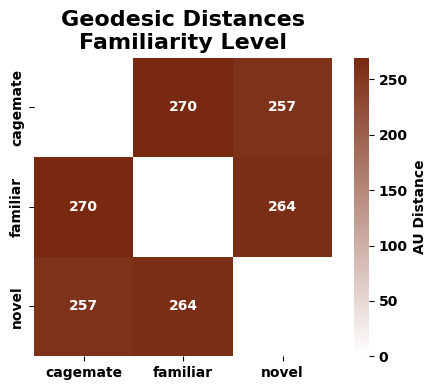

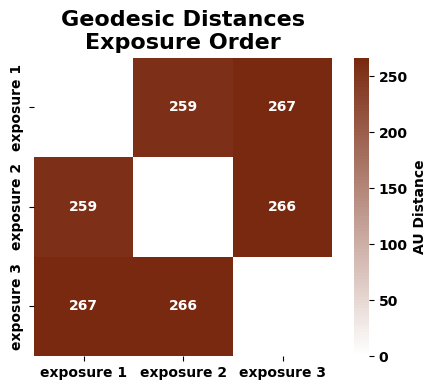

In [21]:
plot_comparison_heatmap(geo_dist_agent, title = "Geodesic Distances\nFamiliarity Level", color = ['white', '#792910'], diagonal_color='white', vmin = 0)
plot_comparison_heatmap(geo_dist_order, title = "Geodesic Distances\nExposure Order", color = ['white', '#792910'], diagonal_color='white', vmin = 0)

c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons


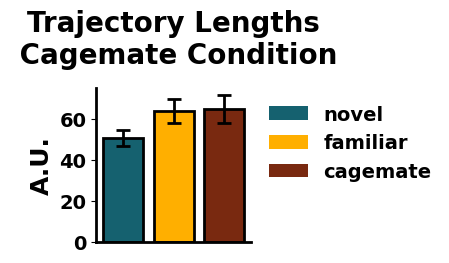

,Comparison,t_statistic,p_value,p_adjusted,significant
0,Nov_Fam,-2.333586,0.039618,0.118854,False
1,Nov_cage,-2.021325,0.068261,0.136522,False
2,fam_Cage,-0.107953,0.915977,0.915977,False


In [27]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in only_subjects_spike.recordings:
    pc_result = pcat.avg_trajectories_pca(recording, event_length = 3, pre_window = 2,
                                                 events = ['novel', 'familiar', 'cagemate'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

agent_colors = ['#15616F',
                '#FFAF00',
                '#792910']
t_nf, p_nf = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,1])
t_nc, p_nc = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,2])
t_fc, p_fc = stats.ttest_rel(trajectory_lengths[:,1], trajectory_lengths[:,2])
p_values = [p_nf, p_nc, p_fc]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['Nov_Fam', 'Nov_cage', 'fam_Cage'],
   't_statistic': [t_nf, t_nc, t_fc],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})


color_id_dict = {'novel': '#15616F', 
                'familiar': '#FFAF00',
                'cagemate': '#792910'}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(300))
# plt.ylim(500,1500)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()
stats_df


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\

Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons


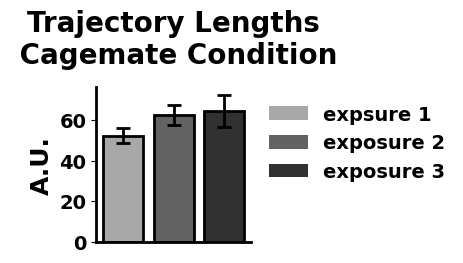

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp2,-1.463547,0.171299,0.342599,False
1,exp1_exp3,-1.745802,0.108675,0.326025,False
2,exp2_exp3,-0.211650,0.836250,0.836250,False


In [28]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in only_subjects_spike.recordings:
    pc_result = pcat.avg_trajectories_pca(recording, event_length = 3, pre_window = 2,
                                                 events = ['exposure 1', 'exposure 2', 'exposure 3'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

agent_colors = ["#A8A8A8",
                "#636363",
                "#313131"]
t_nf, p_nf = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,1])
t_nc, p_nc = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,2])
t_fc, p_fc = stats.ttest_rel(trajectory_lengths[:,1], trajectory_lengths[:,2])
p_values = [p_nf, p_nc, p_fc]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp2', 'exp1_exp3', 'exp2_exp3'],
   't_statistic': [t_nf, t_nc, t_fc],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})


color_id_dict = {'expsure 1': '#A8A8A8', 
                'exposure 2': '#636363',
                'exposure 3': '#313131'}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(300))
# plt.ylim(500,1500)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()
stats_df

In [30]:
import spike.spike_analysis.decoders as decoders 
num_fold = 5
event_length = 3
pre_window = 2
post_window = 0
min_neurons = 5


agent_results = decoders.trial_decoder(only_subjects_spike,
                                              num_fold = num_fold,
                                              no_PCs = 12,
                                              events = ['novel', 'familiar', 'cagemate'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

order_results = decoders.trial_decoder(only_subjects_spike,
                                              num_fold = num_fold,
                                              no_PCs = 12,
                                              events = ['exposure 1', 'exposure 2', 'exposure 3'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 22_NCF_merged.rec with 1 neurons
Excluding 23_CNF_merged.rec with 3 neurons
Excluding 23_NFC_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


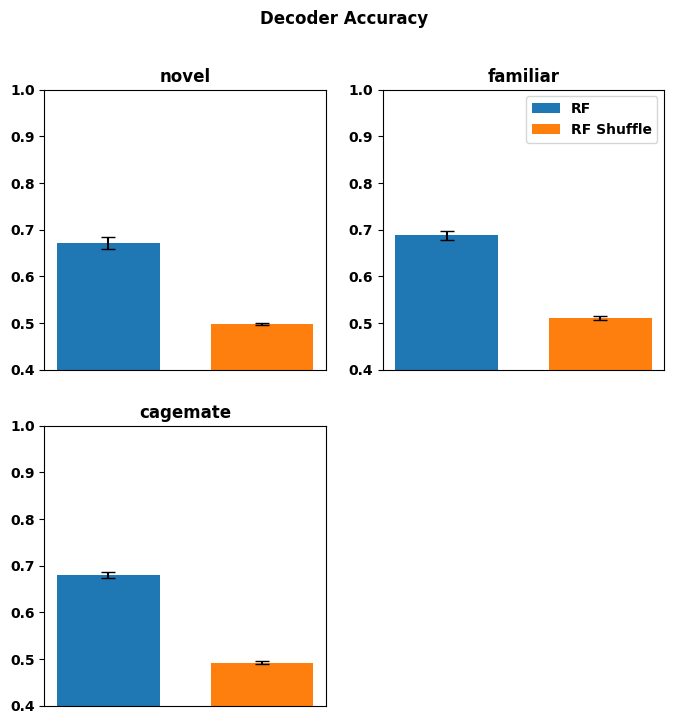

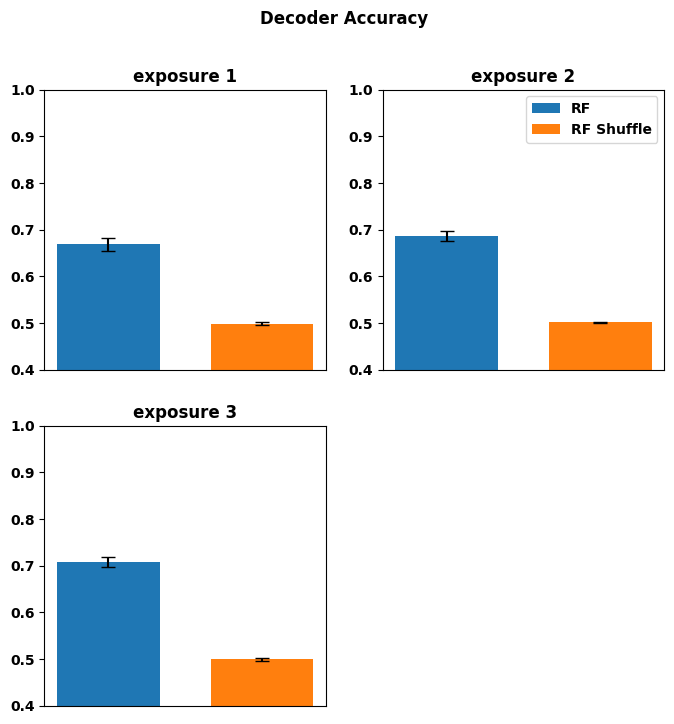

In [31]:
agent_results.plot_average()
order_results.plot_average()

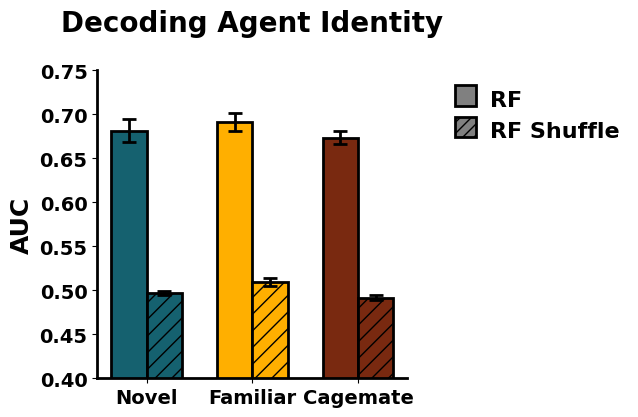

In [35]:
from matplotlib.patches import Patch
def plot_multiple_decoders(decoder_results, title, color_list, legend_titles, figsize, start=0, stop=None, ):
    bar_width = 0.2
    plt.figure(figsize=figsize)
    
    bar_position = 0  # Starting position for bars
    bar_centers = []  # Store center positions for labels
    j = 0
    
    # First, create bars without labels
    for key, results in decoder_results.results.items():
        
        total_event = decoder_results.event_length + decoder_results.post_window
        x = np.linspace(-decoder_results.pre_window, total_event, np.array(results.roc_auc).shape[0])
        
        if start is not None:
            plot_start = np.where(x >= start)[0][0]
        if stop is None:
            plot_stop = results.roc_auc.shape[0]
        if stop is not None:
            plot_stop = np.where(x <= stop)[0][-1] + 1
            
        rf_avg = np.mean(np.mean(results.roc_auc[start:stop], axis=0), axis=0)
        rf_sem = sem(np.mean(results.roc_auc[plot_start:plot_stop], axis=0))
        rf_shuffle_avg = np.mean(np.mean(results.roc_auc_shuffle[plot_start:plot_stop], axis=0), axis=0)
        rf_shuffle_sem = sem(np.mean(results.roc_auc_shuffle[plot_start:plot_stop], axis=0))
        
        # Plot bars without labels
        plt.bar(bar_position, rf_avg, bar_width, 
               yerr=rf_sem, capsize=5, color=color_list[j], 
               edgecolor='black', linewidth=2,
               error_kw={'elinewidth': 2, 'capthick': 2})
        plt.bar(bar_position + bar_width, rf_shuffle_avg, bar_width, 
               yerr=rf_shuffle_sem, capsize=5, color=color_list[j], 
               hatch='//', edgecolor='black', linewidth=2,
               error_kw={'elinewidth': 2, 'capthick': 2})
        
        # Store center position for this pair of bars
        bar_centers.append(bar_position + bar_width/2)
        
        bar_position += 0.6
        j += 1
    
    # Add centered labels under each pair of bars
    plt.xticks(bar_centers, legend_titles, fontsize=12)
    
    # Create custom legend for RF and RF Shuffle
    legend_elements = [
    Patch(facecolor='grey', edgecolor='black', linewidth=2, label='RF'),
    Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='///', label='RF Shuffle')
    ]

    # Create the legend with modified properties
    leg = plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), 
                    frameon=False, fontsize=16)

# Adjust the size of the patches in the legend
    for patch in leg.get_patches():
        patch.set_height(15)  # Adjust this value to change height
        patch.set_y(0)
        patch.set_width(15) 
        patch.set_x(20)
    
    plt.ylim(0.4, .75)
    plt.ylabel('AUC', fontsize=18)
    plt.xticks(fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.title(title, fontsize=20, y = 1.1)
    plt.yticks(fontsize=14)
    plt.show()

plot_multiple_decoders(agent_results, title = "Decoding Agent Identity", color_list =['#15616F', '#FFAF00', '#792910'], start = 0 , stop = 3, legend_titles = ['Novel', 'Familiar', 'Cagemate'], figsize = (4,4))

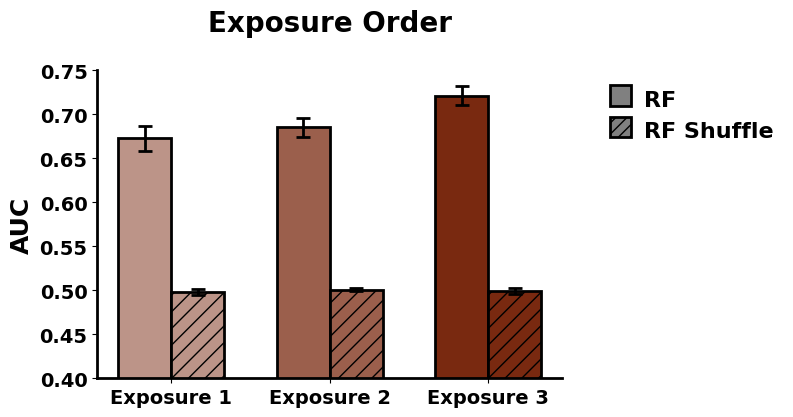

In [38]:
plot_multiple_decoders(order_results, title = "Exposure Order", color_list =exp_colors, start = 0 , stop = 3, legend_titles = ['Exposure 1', 'Exposure 2', 'Exposure 3'], figsize = (6,4))